In [1]:
!pip install torch torchvision

In [2]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:14<00:00, 38.8MB/s]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5),
                           (0.5,0.5,0.5))
  ])
  image = in_transform(image).unsqueeze(0)
  return image

In [8]:
content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg', shape=content.shape[-2:]).to(device)

In [9]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0, 1)
  return image

(-0.5, 599.5, 399.5, -0.5)

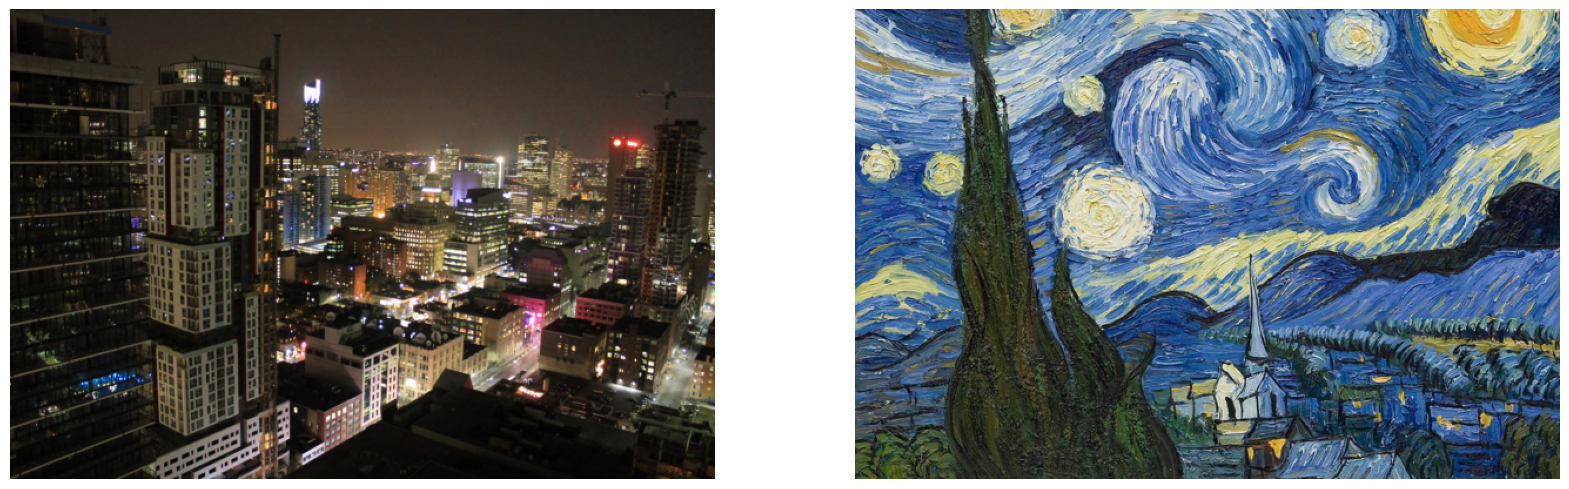

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [34]:
def get_features(image, model):

  layers = {"0": "conv1_1",
            "5": "conv2_1",
            "10": "conv3_1",
            "19": "conv4_1",
            "21": "conv4_2", #Content Extraction
            "28": "conv5_1"}
  features = {}

  for  name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image

  return features


In [35]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [36]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h * w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [37]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [38]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2}
content_weight = 1
style_weight = 1e6


In [48]:
target = content.clone().requires_grad_(True).to(device)

In [49]:
show_every = 300
optimizer = optim.Adam([target], lr = 0.003)
steps = 10000

h, w, channels = im_convert(target).shape
image_array = np.empty(shape = (300, h, w, channels))
capture_frame = steps/300
counter = 0

In [50]:
for ii in range(1, steps + 1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"])**2)
  style_loss = 0

  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss/(d * w * h)

  total_loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii % show_every == 0:
    print("Total Loss: ", total_loss.item())
    print("Iterations: ", ii)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()

  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter += 1

Output hidden; open in https://colab.research.google.com to view.